# Chess ratings - predict future user ratings
---------
This report analyses user ratings in chess. The goal task is to predict how the rating of a user changes in the future - does it increase or stay the same? The second task is to predict future rating (a continuous target).

In this report we first analyse the Chess ratings dataset, then we perform preprocessing - data cleaning and feature construction. Afterwards, we fit multiple models on both the classification and regression tasks. Finally, we choose models with the best results on the validation sets, and we evaluate them on the test sets.

- [Data analysis](#da)
    - [dataset description](#descr)
    - [player data](#player)
    - [titles and ratings](#titles)
- [Preprocessing](#prepro)
    - [basic preprocessing](#basic)
    - [SPARK preprocessing](#spark)
    - [final dataset and splits](#final)
- [Modeling](#model)
- [Evaluation](#eval)
- [Conclusion](#concl)

In [ ]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


data_files = glob.glob("chess_ratings/*.csv")
all_dfs = [pd.read_csv(file, sep='|') for file in data_files]

# Data analysis<a id='da'></a>

## Chess ratings<a id='descr'></a>
The analysed dataset are the Chess ratings from the FIDE.

In [2]:
example_df = all_dfs[5].iloc[:5]
example_df

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon
0,35077023,A Chakravarthy,IND,M,NaN,NaN,NaN,NaN,1151,0,40,1986,i,2018,12
1,10207538,"A E M, Doshtagir",BAN,M,NaN,NaN,NaN,NaN,1840,0,40,1974,i,2018,12
2,5716365,"A Hamid, Harman",MAS,M,NaN,NaN,NI,NaN,1325,0,40,1970,NaN,2018,12
3,10206612,"A K M, Sourab",BAN,M,NaN,NaN,NaN,NaN,1708,0,40,0,i,2018,12
4,5045886,"A K, Kalshyan",IND,M,NaN,NaN,NaN,NaN,1826,0,20,1964,NaN,2018,12


The dataset contains data of chess players registered in FIDE (The International Chess Federation). One example represents data of games and ratings of a player. The data is aggregated by months, and it ranges from December 2017 to December 2019. Both male and female players are represented, there are separate titles for women, but some female players compete in the original categories (mixed gender) as well.

There are over 350k unique players.

In [36]:
data = pd.concat(all_dfs)
data["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(data["Year"], data["Mon"])]
print("Players: " + str(len(data['ID Number'].unique())))

Players: 354525


### Column meanings

Column | Description
--- | ---
'ID Number', 'Name' | ID, name of the player
'Fed', 'Sex', 'B-day' | Country, gender and birth year
'Tit', 'WTit' | Title and female title
'OTit' | Other titles, e.g. Arbiter, Trainer...
'FOA' | FIDE online arena rating
'Rat' | Rating of the player
'Gms' | Number of games played in the month
'K' | development coefficient
'Flag' | (in)activity flag
'Year', 'Mon' | Month and year of the entry


---------------
source: https://ratings.fide.com/download_lists.phtml

K factor: https://en.wikipedia.org/wiki/Elo_rating_system#:~:text=United%20States%20Chess%20Federation%20ratings,-The%20United%20States&text=The%20K-factor,%20in%20the,in%20a%20tournament%20(m).

## Player data and demographics<a id='player'></a>

### Countries
There are players from 192 different countries registered. Czechia is the 10th in player count, and Russia has the most chess players overall. More information about countries is in the first report.

### Player age
The most active players are children and young adults. With age, the interest in chess declines, with a slight increase close to retirement. Elderly people have a decline in active counts probably due to their worse health and lower population count.

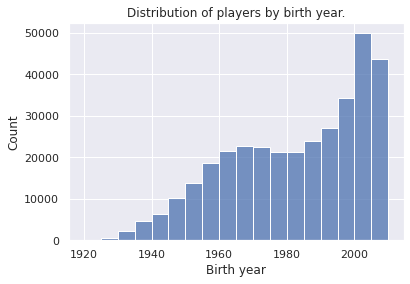

In [10]:
age_ppl = data[['ID Number', 'B-day']].drop_duplicates().reset_index()

plt.title("Distribution of players by birth year.")
sns.histplot(data=age_ppl[age_ppl['B-day'] > 1900], x='B-day', binrange=[1920, 2010], binwidth=5)
plt.xlabel("Birth year")
plt.show()

### Activity

Activity flag is different for women and men competitions. The value nan means "active man", which is bad practice, we will create a new boolean column indicating activity regardless of gender.

In [13]:
data.Flag.unique()

array(['i', nan, 'wi', 'w'], dtype=object)

In [40]:
print(data[data.Flag == 'wi'].Sex.unique())
print(data[data.Flag == 'i'].Sex.unique())

data.loc[data['Flag'] == 'wi', 'Flag'] = 'i'
data.loc[data['Flag'] == 'w', 'Flag'] = ''

['F']
['M']


There is much less women chess players than men chess players.

The distribution of active month counts is mostly uniform, with larger number of players active for 1 year, and a lot of players were active the whole time.

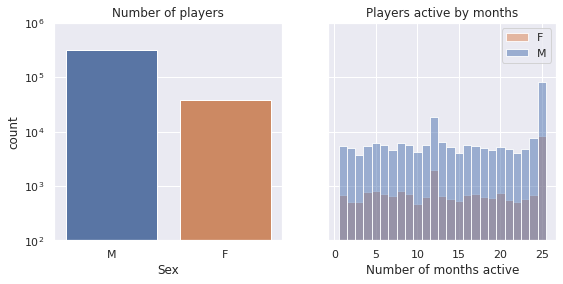

In [18]:
n_years = data[data['Flag'] != 'i'][['ID Number', 'Sex', 'Year']].groupby(['ID Number', 'Sex']).count()

fig, axs = plt.subplots(ncols=2, figsize=(9,4), sharey=True)

sns.countplot(data=data[["ID Number", "Sex"]].drop_duplicates(["ID Number", "Sex"]), x="Sex", ax=axs[0])
plt.ylim(10**2, 10**6)
axs[0].set_xlabel("Sex")
axs[0].set_title("Number of players")
plt.yscale('log')

sns.histplot(data=n_years, x='Year', hue='Sex', discrete=True, log_scale=(False, True), ax=axs[1])
axs[1].legend(["F", "M"], loc='upper right')
plt.ylim(10**2, 10**6)
axs[1].set_xlabel("Number of months active")
axs[1].set_title("Players active by months")
plt.show()

The overall number of registered players increased during the time interval, however number of active players increased at a slower pace.

In [41]:
data['active'] = (data['Flag'] != 'i').astype(int)

In [27]:
inactive_counts = data[["Year", "Mon", "active"]].groupby(["Year", "Mon"]).sum()
inactive_counts = inactive_counts.reset_index()
inactive_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(inactive_counts["Year"], inactive_counts["Mon"])]

In [29]:
all_counts = data[["Year", "Mon", "ID Number"]].groupby(["Year", "Mon"]).count()
all_counts = all_counts.reset_index()
all_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(all_counts["Year"], all_counts["Mon"])]

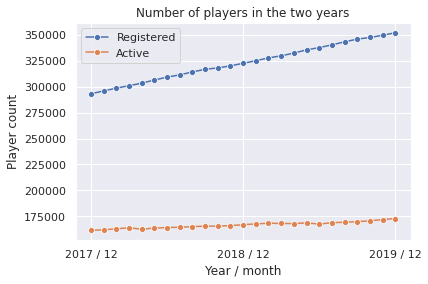

In [30]:
sns.lineplot(data=all_counts, x="Year / month", y="ID Number", marker='o', label='Registered')
sns.lineplot(data=inactive_counts, x="Year / month", y="active", marker='o', label='Active')

plt.xticks(["2017 / 12", "2018 / 12", "2019 / 12"])
plt.title("Number of players in the two years")
plt.ylabel("Player count")
plt.show()

## Titles and ratings<a id='titles'></a>

FIDE arena titles are divers:

In [28]:
data.FOA.unique()

array([nan, 'ACM', 'AIM', 'AFM', 'AGM', 'FI,FA,IA,FT,IO,SIAGM', 'SI,SI',
       'IA', 'FST', 'IO', 'FI    AIM', 'IO,FT', 'FT', 'SI', 'IA    AGM',
       ',IO', 'IA,SI', 'FI', 'DI'], dtype=object)

For simplicity, we will focus on the main rating classes. The titles of FIDE are the following:

- CM - Candidate Master
- FM - FIDE Master
- IM - International Master
- GM - Grand Master

Women titles have a prefix of "W". The titles are achieved by 11 % of women and only 5 % of men.

More data about the titles can be found in the previous report.

The rating distributions match the prestige of a title, with better titles awarded to higher ranking players. In the male division, the rating distributions are more narrow than in the female section. The FIDE master title is occassionally achieved by some players with a low rating, while the better titles are awarded mostly to players with a very high rating

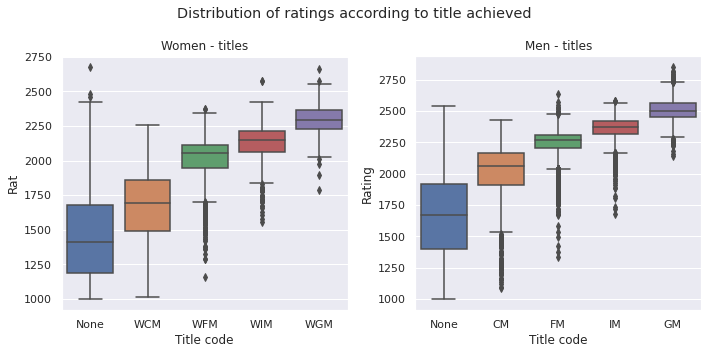

In [31]:
data["WTit_filled"] = data["WTit"].fillna('None')
data["Tit_filled"] = data["Tit"].fillna('None')


def group_rating(d, title):
    name = f"{title}_filled"
    d[name] = d[title].fillna("None")
    
    return d[["ID Number", "Rat", name]].groupby(["ID Number", name]).mean().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=group_rating(data[data["Sex"] == "F"].copy(), "WTit"), x='WTit_filled', y="Rat",
            order=["None", "WCM", "WFM", "WIM", "WGM"], ax=axs[0])
plt.ylabel("Rating")

sns.boxplot(data=group_rating(data[data["Sex"] == "M"].copy(), "Tit"), x='Tit_filled', y="Rat",
            order=["None", "CM", "FM", "IM", "GM"], ax=axs[1])

axs[0].set_title("Women - titles")
axs[1].set_title("Men - titles")

plt.suptitle("Distribution of ratings according to title achieved")
plt.ylabel("Rating")
axs[0].set_xlabel("Title code")
axs[1].set_xlabel("Title code")
plt.tight_layout()
plt.show()

Finally, we analyzed the score of players that were active in the whole period of 2 years. Specifically, we analyzed how much the score from 12/2019 improved compared to 12/2017. We plot the difference between the two scores.

In the male section, half of the players got better and the other half got worse. For most players, the score difference was not that large, however there were some outliers with a very large improvement. In the female category, slightly more than a half improved, and the score differences were for most players quite noticeable.

Number of players active the whole time:  89077


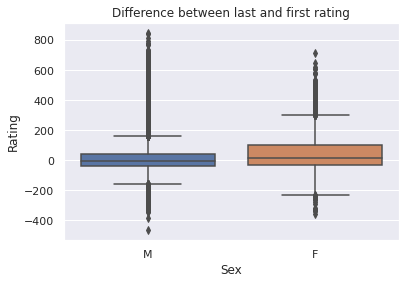

In [42]:
active_ppl = data[data["active"] == 1][["ID Number", "Mon"]].groupby("ID Number").count()

all_timers = active_ppl[active_ppl["Mon"] == 25]
all_timers = data[data["ID Number"].isin(all_timers.index)].reset_index()
print("Number of players active the whole time: ", len(all_timers["ID Number"].unique()))

first_month = all_timers[all_timers["Year / month"] == "2017 / 12"].set_index("ID Number")
last_month = all_timers[all_timers["Year / month"] == "2019 / 12"].set_index("ID Number")

rating_diff = last_month["Rat"] - first_month["Rat"]
rating_diff = rating_diff.to_frame()
rating_diff["Sex"] = first_month["Sex"]

plt.title("Difference between last and first rating")
sns.boxplot(data=rating_diff, x="Sex", y="Rat")
plt.ylabel("Rating")
plt.show()

# Preprocessing<a id='prepro'></a>

There are some changes, errors or inconsistencies in the data.

1. some players (2549) changed their name - some due to typos or name change after marriage
2. some players changed their gender - apart from errors, this could mean they are trans
3. some changed their birth year
4. some players changed their country

In the modeling, we won't use player names and their countries, as names are not relevant features and countries would lead
to a large feature space. As so, problems **1. and 4. don't need to be solved**.

### Gender changes

In [55]:
dupl_gender = data[['ID Number', 'Sex', 'Flag']].groupby(['ID Number', 'Sex']).count().reset_index()
dupl_gender = dupl_gender[dupl_gender.duplicated('ID Number')]
print(f"Number of gender changes: {len(dupl_gender)}")

Number of gender changes: 363


Since the number of people who changed gender is relatively small, we will drop them. 

### Wrong years
If the birth year is 0 and was changed later on, we try to fill it with the correct value. Otherwise we **drop all rows** with people **younger than 5 years** or **older than 110 years**.

## Basic preprocessing - summary<a id='basic'></a>
- we drop people with changing gender
- we drop or fill invalid birth years
- we unify the activity flag column to be gender-independent
- we convert both mixed and female titles to numerical representation
    - ordered by importance (see distribution of ratings by title plot)
    - from worst to best - `["None", "CM", "FM", "IM", "GM"]`

All steps are done in the function `preprocess_data`

In [2]:
from spark_utils import preprocess_data

data = pd.concat(all_dfs)
data = preprocess_data(data)

In [ ]:
print("Titles converted to numerical values:")
print(data['tit'].unique())
print(data['wtit'].unique())

## SPARK preprocessing<a id='spark'></a>
`pyspark` was used mainly to aggregate the data. As described in the introduction, for every player we want to predict if their rating changed. This means that we need data in the format `user, y`, but raw data contains multiple rows per user.

An example of aggregated features is shown below:

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "20g") \
    .appName('chess-app') \
    .getOrCreate()

In [5]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.sparkContext.setLogLevel("ERROR")

df = spark.createDataFrame(data)
df.show(3)

+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+---+---+----+
|ID Number|            Name|Fed|Sex|Tit|WTit|OTit|FOA| Rat|Gms|  K|B-day|Flag|Year|Mon|age|tit|wtit|
+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+---+---+----+
| 35077023|  A Chakravarthy|IND|  M|   |    |    |   |1151|  0| 40| 1986|   i|2018|  8| 33|  0|   0|
| 10207538|A E M, Doshtagir|BAN|  M|   |    |    |   |1840|  0| 40| 1974|   i|2018|  8| 45|  0|   0|
|  5716365| A Hamid, Harman|MAS|  M|   |    |  NI|   |1325|  6| 40| 1970|    |2018|  8| 49|  0|   0|
+---------+----------------+---+---+---+----+----+---+----+---+---+-----+----+----+---+---+---+----+
only showing top 3 rows



In [82]:
from spark_utils import get_mean, get_sum, get_string, reduce_by_months, get_max

red = reduce_by_months(df, 'Rat', get_mean, agg_func_name='mean', n_months=12) \
        .groupBy('ID Number') \
        .pivot('Colname') \
        .max('Rat:mean')

red.show(5)

+---------+---------------------+---------------------+---------------------+
|ID Number|Rat:mean/2017//yearly|Rat:mean/2018//yearly|Rat:mean/2019//yearly|
+---------+---------------------+---------------------+---------------------+
| 42507359|               1577.0|               1577.0|   1529.3333333333333|
|   928453|               2048.0|               2048.0|   2047.3333333333333|
|  3520005|               2033.0|               2033.0|               2033.0|
| 24646245|               1742.0|               1742.0|               1742.0|
| 46628100|               1466.0|               1466.0|               1466.0|
+---------+---------------------+---------------------+---------------------+
only showing top 5 rows



The resulting features are the mean rating of a person aggregated by years. Smaller granularity (e.g. aggregate per 3 months) is also possible, as well as different aggregation methods. The implementation can be found in `spark_utils.py`.

The aggregation works like this:
1. map the rows to tuples (id, time, value). Time is date / granularity for example:
    - 2/2018 aggregated by 3 months -> time is 0/2018
    - 4/2018 aggregated by 3 months -> time is 1/2018
2. reduce the row tuples to (id, time, aggregated value)
    - for numerical values - `mean(values)`, `max(values)` or `sum(values)`
    - for strings - longest value
3. pivot the dataset
    - from `(id, time, value)` to `(id, time_1/value_1, time_2/value_2, ...)`

## Final dataset<a id='final'></a>
The final dataset is created by aggregating row values for some columns (as described above) and including some general data about the people.

We aggregate the following features:
- Flag - i if inactive anywhere in the period
- Gms - sum of games played
- Rat - mean rating
- tit, wtit - highest title in the period

We also include Sex, K, and age features. Sex and K are kept as-is, age is `2019 - B-day` and then binned by 10 years.

**Final preprocessing**:
- numerical columns are filled with 0 and Flag is filled with 'i'
- age, Sex and K and Flag columns are one hot encoded

In [10]:
from experiments import create_dataset

dataset = create_dataset(df, n_months=6, last_year=2019, last_month=6)

In [94]:
print(dataset[0].columns)
c_for_show = [c for c in dataset[0].columns if '/' not in c or '2017' in c]
dataset[0][c_for_show].head()

Index(['ID Number', 'Sex', 'K', 'age', 'Flag:str/2017/6/6',
       'Flag:str/2018/0/6', 'Flag:str/2018/6/6', 'Flag:str/2019/0/6',
       'Gms:sum/2017/6/6', 'Gms:sum/2018/0/6', 'Gms:sum/2018/6/6',
       'Gms:sum/2019/0/6', 'Gms:mean/2017/6/6', 'Gms:mean/2018/0/6',
       'Gms:mean/2018/6/6', 'Gms:mean/2019/0/6', 'Rat:mean/2017/6/6',
       'Rat:mean/2018/0/6', 'Rat:mean/2018/6/6', 'Rat:mean/2019/0/6',
       'tit:max/2017/6/6', 'tit:max/2018/0/6', 'tit:max/2018/6/6',
       'tit:max/2019/0/6', 'wtit:max/2017/6/6', 'wtit:max/2018/0/6',
       'wtit:max/2018/6/6', 'wtit:max/2019/0/6'],
      dtype='object')


,ID Number,Sex,K,age,Flag:str/2017/6/6,Gms:sum/2017/6/6,Gms:mean/2017/6/6,Rat:mean/2017/6/6,tit:max/2017/6/6,wtit:max/2017/6/6
0,100170,M,20,"(25, 35]",i,0.0,0.0,1930.0,0.0,0.0
1,100323,M,10,"(50, 65]",i,0.0,0.0,2389.0,3.0,0.0
2,100552,M,10,"(50, 65]",,7.0,7.0,2403.0,2.0,0.0
3,101435,M,20,"(75, 110]",i,0.0,0.0,2310.0,3.0,0.0
4,101583,M,40,"(35, 50]",i,0.0,0.0,2237.0,0.0,0.0


### X, y split<a id='split'></a>

The data is split like this:

- X (input matrix) contains these features:
    - Sex, K, age
    - all aggregated features until the split year/month (e.g. until 2019/6)
- y (target) for classification
    - we use 1/0 indicator of `Rat/year/month > Rat/prev_year_month + diff`
        - e.g. for half year splits, `Rat/2019/6 > Rat/2019/0 + 10`
        - diff indicates only a small rating change
        - `y == 1` if the person got better in the second half of 2019, `y == 0` if they got worse
- y (target) for regression
    - exact rating ... `Rat/year/month`
        - e.g. `Rat/2019/6`
    - rating difference ... `Rat/year/month - Rat/prev_year_month`
        - e.g. `Rat/2019/6 - Rat/2019/0`

For example, these are the (raw) columns for X:

In [99]:
dataset[0][c_for_show].head()

,ID Number,Sex,K,age,Flag:str/2017/6/6,Gms:sum/2017/6/6,Gms:mean/2017/6/6,Rat:mean/2017/6/6,tit:max/2017/6/6,wtit:max/2017/6/6
0,100170,M,20,"(25, 35]",i,0.0,0.0,1930.0,0.0,0.0
1,100323,M,10,"(50, 65]",i,0.0,0.0,2389.0,3.0,0.0
2,100552,M,10,"(50, 65]",,7.0,7.0,2403.0,2.0,0.0
3,101435,M,20,"(75, 110]",i,0.0,0.0,2310.0,3.0,0.0
4,101583,M,40,"(35, 50]",i,0.0,0.0,2237.0,0.0,0.0


Splitted feature names are `feature:agg_method/year/month/granularity`.

These are the remaining columns, `Rat:mean/2019/6/6` will be used for y:

In [100]:
dataset[1].head()

,Flag:str/2019/6/6,Gms:sum/2019/6/6,Gms:mean/2019/6/6,Rat:mean/2019/6/6,tit:max/2019/6/6,wtit:max/2019/6/6
0,i,0.0,0.0,1930.000000,0.0,0.0
1,i,0.0,0.0,2389.000000,3.0,0.0
2,,18.0,3.0,2366.333333,2.0,0.0
3,i,0.0,0.0,2310.000000,3.0,0.0
4,i,0.0,0.0,2237.000000,0.0,0.0


### Train - validation - test

We split the data to train, validation and test set. Validation set is used for model selection, test set is for final evaluation.

Since the classification dataset is unbalanced (for most people, the rating stayed the same ... label 0), we use stratified splits.

In [19]:
from model_utils import get_data_split

seed = 42
splits = get_data_split(dataset, random_state=seed)

In [23]:
print("Train size: ", len(splits['data'][0]), "\tpositive: ", sum(splits['data'][2]))
print("Val size: ", len(splits['data'][1]), "\tpositive: ", sum(splits['data'][3]))
print("Test size: ", len(splits['test'][0]), "\tpositive: ", sum(splits['test'][1]))

Train size:  242037 	positive:  37390
Val size:  34577 	positive:  5341
Test size:  69154 	positive:  10683


# Modeling<a id='model'></a>

As a model, we will use a very simple pipeline - a PCA followed by a Random Forest (RF). We examine three PCA variants - 2, 10 and 20 components, and three RF variants - with 50, 100 and 500 estimators.

In [ ]:
from model_utils import make_models

models = make_models()
list(models.keys())

Furthermore, we evaluate the 9 models on multiple datasets - classification and regression tasks with different data splits.

We have three base cases (described [above](#split))
- classification (did the person get a better rating?)
- regression (predict rating of the person)
- regression, rating diff (predict rating change)

For every case, we use three splits:
- features aggregated per month, predict December 2019
- features aggregated per half year, predict second half of 2019
- features aggregated per years, predict 2019

This means we have 9 datasets total, leading to 81 model fits.

In [16]:
import pickle

y_splits = [
    (1, 11),
    (6, 6),
    (12, None)
]

load_datasets = True

if load_datasets:
    with open('data.pickle', 'rb') as f:
        datasets = pickle.load(f)
else:
    datasets = {}

    for n_months, last_month in y_splits:    
        print(n_months)
        # y discrete (1/0)
        datasets[f"clf_{n_months}"] = create_dataset(df, n_months=n_months, last_year=2019, last_month=last_month)
        # y continuous
        datasets[f"regr_{n_months}"] = create_dataset(df, n_months=n_months, last_year=2019, last_month=last_month,
                                                      y_discrete=False)
        # y continuous, diff
        datasets[f"regrdiff_{n_months}"] = create_dataset(df, n_months=n_months, last_year=2019, last_month=last_month,
                                                          y_discrete=False, continuous_diff=True)

For every dataset, we save the predictions and metrics for all models. In the classification task, we compute the AUC and accuracy, in regression tasks, we compute RMSE and Pearson's correlation coefficient r.

We also compute the metrics on a baseline
- for classification, we predict the majority class (0 - no changes or worse)
- for rating prediction, we predict the rating in the previous time period (last one in training data)
- for rating difference prediction, we predict 0 - no change
    - in this case, pearson's r is not defined since the baseline is constant

In [ ]:
import os
import pickle
from model_utils import eval_multiple_models, make_models, get_data_split, eval_baseline

seed = 42
n_jobs = 24

for key, d in datasets.items():
    if os.path.exists(f"{key}.csv"):
        continue
    print(key)
    
    is_clf = 'regr' not in key
    splitted_d = get_data_split(d, is_clf=is_clf, random_state=seed, val_size=0.1, test_size=0.2)
    
    vdf, tdf = eval_baseline(splitted_d, is_clf=is_clf)
    vdf.to_csv(f"{key}_valbase.csv", index=False)
    tdf.to_csv(f"{key}_testbase.csv", index=False)
    
    models = make_models(is_clf=is_clf, n_jobs=n_jobs)
    preds, df = eval_multiple_models(splitted_d, models, is_clf=is_clf)
    
    df.to_csv(f"{key}.csv", index=False)
    with open(f"{key}.pickle", 'wb') as f:
        pickle.dump(preds, f)

In [57]:
def fix_pears(b):
    b['pearson\'s_r'] = [eval(v)[0] for v in b['pearson\'s_r']]

We load the predicted metrics and plot the results for each of the 3 task types.

In [109]:
res_dfs = {'clf': [], 'regrdiff': [], 'regr': []}

for k in datasets.keys():
    rdf = pd.read_csv(f"{k}.csv")
    rdf['task_name'] = k
    
    if 'regr' in k:
        fix_pears(rdf)
    
    # add to correct list
    for rk in res_dfs.keys():
        if rk in k:
            res_dfs[rk].append(rdf)
            break
            
res_dfs = {k: pd.concat(v).reset_index(drop=True) for k, v in res_dfs.items()}

### Classification

We plot the results for the three classification tasks, **baselines** for every task are in the **same color but dashed**.
- predict december 2019 (`clf_1`)
- predict second half of 2019 (`clf_6`)
- predict 2019 rating (`clf_12`)

Overall, the results increase with larger n_components in PCA. For n_estimators, the results for 100 and 500 estimators seem to be similar. All models surpass their baselines (dashed lines)

The `clf_1` task is the hardest - the accuracy is very high, but the AUC is very low, indicating that the model predicts mostly the majority class.

For the other two tasks, the AUC improves significantly, but the accuracy drops - the model learns to predict some of the positive cases (person got better), but makes some mistakes on the negative ones (person stayed the same or got worse).

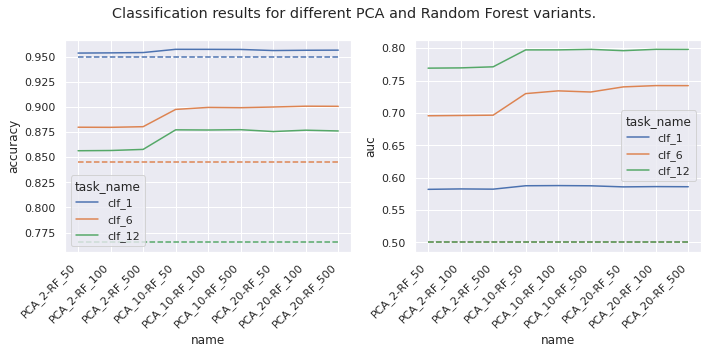

In [115]:
from fig_utils import draw_metrics

baselines = [pd.read_csv(f'clf_{i}_valbase.csv') for i in ['1', '6', '12']]
draw_metrics(res_dfs['clf'], 'accuracy', 'auc', baselines,
             title="Classification results for different PCA and Random Forest variants.")

In all regression tasks, the models surpassed their baselines - the previous rating. In case of predicting the next month, the previous rating was a strong baseline, very close to the final results. The results improve again with more PCA components, yet 10 components are enough in this case.

The models performed well for `regr_1` and `regr_6`, but the results were slightly worse for `regr_12`. The reason could be that there are only few relevant features in the X data compared to the other granularities - e.g. for Rating, we only have `Rat:2017` and `Rat:2018` as features, whereas for `regr_6` we have 4 Rating-related features total.

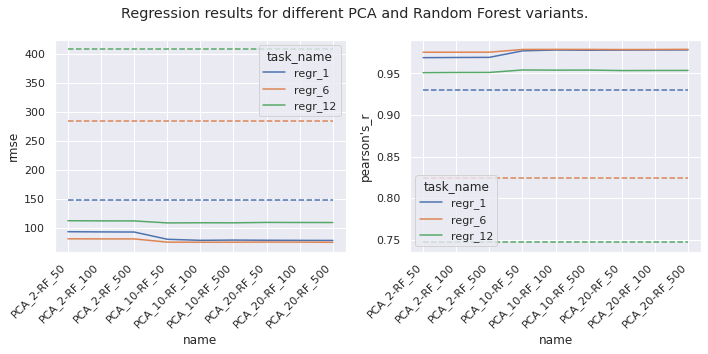

In [117]:
baselines = [pd.read_csv(f'regr_{i}_valbase.csv') for i in ['1', '6', '12']]
[fix_pears(b) for b in baselines]
draw_metrics(res_dfs['regr'], 'rmse', 'pearson\'s_r', baselines,
             title="Regression results for different PCA and Random Forest variants.")

The task where we predict the difference (how much the rating got better/worse) is similar to the previous regression task. The accuracy results are similar, but the correlation results differ - the next half year and next year results are the same, and next month (`regrdiff_1`) is much worse. The reason could be that it is harder to predict small fluctuations in rating.

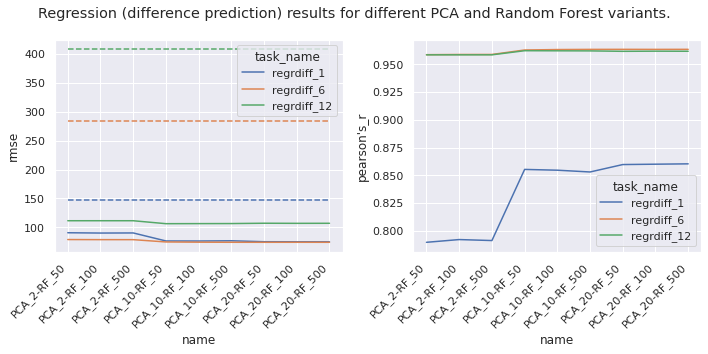

In [118]:
baselines = [pd.read_csv(f'regrdiff_{i}_valbase.csv') for i in ['1', '6', '12']]
draw_metrics(res_dfs['regrdiff'], 'rmse', 'pearson\'s_r', baselines, plot_2=False,
             title="Regression (difference prediction) results for different PCA and Random Forest variants.")

# Evaluation<a id='eval'></a>

For the final evaluation, we use the model `PCA_20-RF_100` for code simplicity, as it was the best for all datasets and task types.

In [ ]:
import os
import pickle
from model_utils import eval_model_on_data, make_models, get_data_split, eval_preds

seed = 42
n_jobs = 24

metrics = {}
pred_dict = {}

for key, d in datasets.items():
    print(key)
   
    is_clf = 'regr' not in key
    splitted_d = get_data_split(d, is_clf=is_clf, random_state=seed, val_size=0.1, test_size=0.2)
    
    models = make_models(is_clf=is_clf, n_jobs=n_jobs)
    final_model = models['PCA_20-RF_100']
    
    eval_model_on_data(splitted_d, final_model, is_clf=is_clf)
    
    xtest, ytest, idxtest = splitted_d['test']
    preds = final_model.predict(xtest)
    metrics[key] = eval_preds(ytest, preds, is_clf=is_clf)
    pred_dict[key] = preds

In [116]:
res_dfs = {'clf': [], 'regrdiff': [], 'regr': []}

for k, v in metrics.items():
    r = v.copy()
    r['name'] = k
    r['type'] = 'predicted'

    base = pd.read_csv(f'{k}_testbase.csv')
    base['name'] = k
    base['type'] = 'baseline'
    
    for kr in res_dfs.keys():
        if kr in k:
            res_dfs[kr].append(r)
            res_dfs[kr].append(base.iloc[0].to_dict())
            break
    
res = {k: pd.DataFrame(r) for k, r in res_dfs.items()}

### Test set results
The final results are plotted below. We can see that the results are similar to the validation set results.

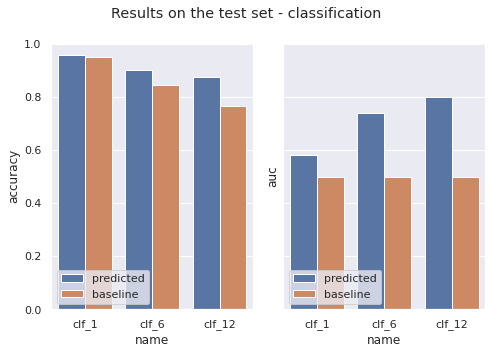

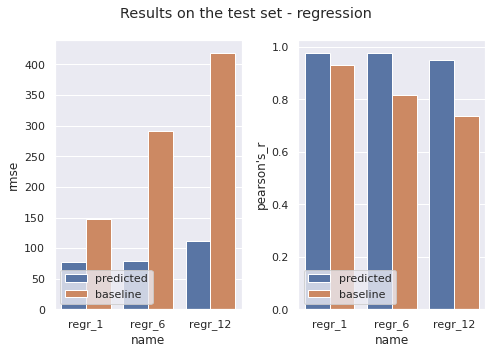

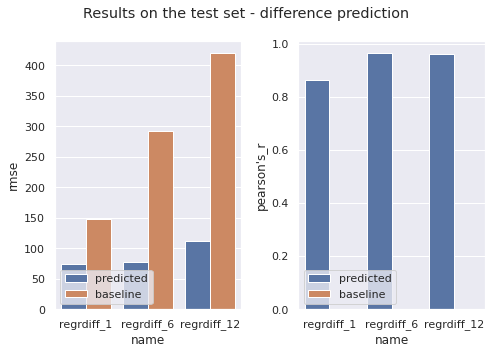

In [117]:
from fig_utils import plot_final_results

plot_final_results(res['clf'], 'accuracy', 'auc', title='Results on the test set - classification', sharey=True)

res['regr']['pearson\'s_r'] = res['regr']['pearson\'s_r'].astype(str)
fix_pears(res['regr'])
plot_final_results(res['regr'], 'rmse', 'pearson\'s_r', title='Results on the test set - regression')

res['regrdiff']['pearson\'s_r'] = [((0,0) if 'nan' in r else r) for r in res['regrdiff']['pearson\'s_r']]
res['regrdiff']['pearson\'s_r'] = res['regrdiff']['pearson\'s_r'].astype(str)
fix_pears(res['regrdiff'])
plot_final_results(res['regrdiff'], 'rmse', 'pearson\'s_r',  title='Results on the test set - difference prediction')

### Confusion matrix
Additionally, we plot the confusion matrices for the classification tasks. We see that `clf_1` has much less positive cases - this is what I forgot during the model fitting, and it makes sense - people could have improved throughout the year, but not exactly in December 2019. This also explains the good accuracy on `clf_1` but bad AUC.

We can see that there is still a lot of mistakes. The reasons will be discussed in the conclusion.

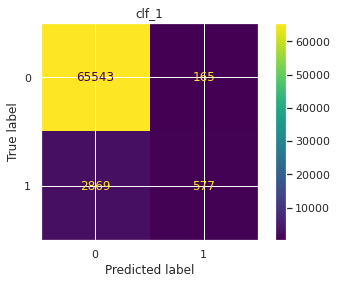

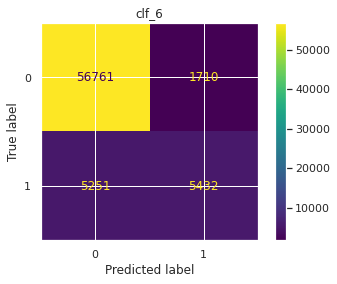

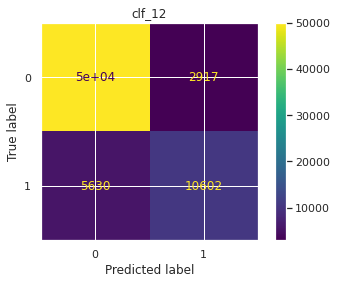

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for k, p in pred_dict.items():
    if 'clf' not in k:
        continue
        
    splitted_d = get_data_split(datasets[k], is_clf=True, random_state=seed, val_size=0.1, test_size=0.2)
    y_test = splitted_d['test'][1]
    cm = confusion_matrix(y_test, p, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot()
    plt.title(k)
    plt.show()

# Conclusion<a id='concl'></a>

We analysed the Chess ratings dataset and we predicted future ratings of players - 0/1 improvement, exact rating prediction and difference between previous and next rating. We created 3 different datasets - features aggregated per 1 month, half a year and 1 year.

We separated the data into train, validation and test sets, we fit several models on the train set and evaluated on the validation set. We chose the model with best results on the validation set for the final evaluation, and reported results on the test set along with confusion matrices.

The results were quite good - we were able to predict rating changes better that the baselines (0 - no improvement for 0/1, previous rating for exact prediction, and 0 for difference prediction). This means that it is indeed possible to predict future rating only from previous ratings, games played, titles awarded, activity and gender.

Although the results were better than the baselines, the number of mistakes was still quite high. Possible improvements could be better model or preprocessing selection, or we could combine all features from all the splits - i.e. 1 month features, features aggregated over half a year etc. However, it could also be that it is not possible to predict more - the rating could change due to some events not captured in data, e.g. illness of the player that leads to worse results.